# Thrombolysis hospital vs. benchmark diagrams and patient vignettes

In this notebook we present means of comparing use of thrombolysis in a particular hospital to our benchmark set of hospitals. At the hospital level we illustrate the comparison with Graph and Venn diagrams. We then pick individual patients which illustrate something about that hospital, and embellish the SSNAP data with synthetic details in order to provide a discussion vignette for physicians. 

Here we illustrate, though hospital-level diagrams and patient-level vignettes, two example areas of differences in treatment decisions:

1. A hospital with lower-than-usual use of thrombolysis in patients with mild stroke

1. A hospital with lower-than-usual use of thrombolysis in patients with prior disability

## Import libraries

In [1]:
import os
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 110)
import numpy as np
import graphviz as gv

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_venn import venn2, venn2_circles
import matplotlib.gridspec as gridspec

from IPython.display import Image 

## Function for Venn diagram plotting

Venn diagrams are plotted using the matplotlib-venn library (`pip install matplotlib-venn`).

In [2]:
def plot_venn(df, hospital, save=False):
    
    patients = df.loc[df['StrokeTeam']==hospital]
    
    throm = len(patients.loc[patients['S2Thrombolysis']==1])
    majority_throm = len(patients.loc[patients['Benchmark']==1])
    
    no_throm = len(patients.loc[patients['S2Thrombolysis']==0])
    majority_no_throm = len(patients.loc[patients['Benchmark']==0])
    
    agree_throm = len(patients.loc[(patients['S2Thrombolysis'] == 1) & (patients['Benchmark']==1)])
    agree_no_throm = len(patients.loc[(patients['S2Thrombolysis'] == 0) & (patients['Benchmark']==0)])
    
    
    
    rate = round(throm*100 / (throm + no_throm),1)
    agree = round((agree_throm + agree_no_throm)/(throm + no_throm),1)
    
    
    fig, ax = plt.subplots(1,3, figsize = (15,5))
    
    ax[2].axis('off')
    
    ax[2].text(0.3, 0.8, 'N Patients: {0}'.format(len(patients)), horizontalalignment='left',
        verticalalignment='center', size=18)
    
    ax[2].text(0.3, 0.7, 'Thrombolysis rate (%): {0}'.format(rate), horizontalalignment='left',
        verticalalignment='center', size=18)
    
    ax[2].text(0.3, 0.6, 'Agreement (%): {0}'.format(agree*100), horizontalalignment='left',
        verticalalignment='center', size=18)
    
    
    ax[0].set_title('Thrombolysed', fontsize=18)
    
    f1 = venn2(subsets = (throm-agree_throm, majority_throm-agree_throm, agree_throm), 
          set_labels = ('Hospital', 'Benchmark'), set_colors=('yellow', 'blue'), alpha = 0.7, ax=ax[0])
    f1.get_patch_by_id('11').set_color('green')
    
    venn2_circles(subsets = (throm-agree_throm, majority_throm-agree_throm, agree_throm), 
                  lw=1, alpha=0.5, ax=ax[0])
    
    for text in f1.set_labels:
        text.set_fontsize(16)
        text.set_fontweight('bold')
    for text in f1.subset_labels:
        text.set_fontsize(16)
    
    ax[1].set_title('Not Thrombolysed', fontsize=18)
    
    f2 = venn2(subsets = (no_throm-agree_no_throm, majority_no_throm-agree_no_throm, agree_no_throm),
          set_labels = ('Hospital', 'Benchmark'), set_colors=('yellow', 'blue'), alpha = 0.7, ax=ax[1])
    f2.get_patch_by_id('11').set_color('green')
    
    venn2_circles(subsets = (no_throm-agree_no_throm, majority_no_throm-agree_no_throm, agree_no_throm),
                  lw=1, alpha=0.5, ax=ax[1])
    
    for text in f2.set_labels:
        text.set_fontsize(16)
        text.set_fontweight('bold')
    for text in f2.subset_labels:
        text.set_fontsize(16)
    
    if save==True:
        
        plt.savefig('./figures/vignettes/venn_{0}.jpg'.format(hospital), dpi=300)
        
    plt.show()

## Function for decision graph plotting

Decision graph plots are performed using graphviz (`pip install graphviz`).

In [3]:
def plot_graph(df, hospital, save=False):
    
    patients = df.loc[df['StrokeTeam']==hospital]
    
    throm = len(patients.loc[patients['S2Thrombolysis']==1])
    
    no_throm = len(patients.loc[patients['S2Thrombolysis']==0])
    
    
    agree_throm = len(patients.loc[(patients['S2Thrombolysis'] == 1) & (patients['Benchmark']==1)])
    agree_no_throm = len(patients.loc[(patients['S2Thrombolysis'] == 0) & (patients['Benchmark']==0)])
    
    disagree_throm = len(patients.loc[(patients['S2Thrombolysis'] == 1) & (patients['Benchmark']==0)])
    disagree_no_throm = len(patients.loc[(patients['S2Thrombolysis'] == 0) & (patients['Benchmark']==1)])
    
    # N prop to w^2/4, h^2/4
    
    dot = gv.Digraph(comment='{0}'.format(hospital))
    
    dot.attr('node', shape='circle', width='2', height='2', fixedsize='true')
    
    dot.node('H', 'Hospital\nAdmissions:\n{0}'.format(len(patients)))

    dot.node('T', 'Hospital\nThrombolysed:\n{0}'.format(throm),\
             style='filled', fillcolor='#FFFD6B')
    
    dot.node('N', 'Hospital Not\nThrombolysed:\n{0}'.format(no_throm),\
            style='filled', fillcolor='#FFFD6B')
    
    dot.node('A', 'Benchmark\nThrombolysed:\n{0}'.format(agree_throm),\
             style='filled', fillcolor='#00CC0F')
    dot.node('B', 'Benchmark Not\nThrombolysed:\n{0}'.format(disagree_throm), \
            style='filled', fillcolor='#4E73F9')
    
    dot.node('C', 'Benchmark Not\nThrombolysed:\n{0}'.format(agree_no_throm),\
             style='filled', fillcolor='#00CC0F')
    dot.node('D', 'Benchmark\nThrombolysed:\n{0}'.format(disagree_no_throm),\
             style='filled', fillcolor='#4E73F9')

    dot.edges(['HT', 'HN', 'TA', 'TB', 'NC', 'ND'])

    
    #dot.render('./figures/vignettes/graph_{0}.gv'.format(hospital), view=True) 
    dot.render('./figures/vignettes/graph_{0}.gv'.format(hospital), view=False, format='png')
    
    return dot

## Load data

In [4]:
# Load dataset
data = pd.read_csv('./data/vignette_data.csv', index_col=0)

In [5]:
data.shape

(88928, 107)

## Identify Confident Misclassifications

Identify patients where model has 90% probability of thrombolysis, but patient was not given thrombolysis.

In [6]:
confident = data.loc[(data['S2Thrombolysis']==0) & (data['Probability']>=0.9)]

In [7]:
confident

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,MotorArmLeft,MotorArmRight,MotorLegLeft,MotorLegRight,LimbAtaxia,Sensory,BestLanguage,Dysarthria,ExtinctionInattention,S2NihssArrival,S2BrainImagingTime_min,MoreEqual80y_No,MoreEqual80y_Yes,S1Gender_Female,S1Gender_Male,S1Ethnicity_Asian,S1Ethnicity_Black,S1Ethnicity_Mixed,S1Ethnicity_Other,S1Ethnicity_White,S1OnsetInHospital_No,S1OnsetInHospital_Yes,S1OnsetDateType_Best estimate,S1OnsetDateType_Precise,S1OnsetDateType_Stroke during sleep,S1OnsetTimeType_Best estimate,S1OnsetTimeType_Not known,S1OnsetTimeType_Precise,S1ArriveByAmbulance_No,S1ArriveByAmbulance_Yes,S1ArriveByAmbulance_missing,S1AdmissionHour_00:00 to 02:59,S1AdmissionHour_03:00 to 05:59,S1AdmissionHour_06:00 to 08:59,S1AdmissionHour_09:00 to 11:59,S1AdmissionHour_12:00 to 14:59,S1AdmissionHour_15:00 to 17:59,S1AdmissionHour_18:00 to 20:59,S1AdmissionHour_21:00 to 23:59,S1AdmissionDay_Friday,S1AdmissionDay_Monday,S1AdmissionDay_Saturday,S1AdmissionDay_Sunday,S1AdmissionDay_Thursday,S1AdmissionDay_Tuesday,S1AdmissionDay_Wednesday,S1AdmissionQuarter_Q1,S1AdmissionQuarter_Q2,S1AdmissionQuarter_Q3,S1AdmissionQuarter_Q4,S1AdmissionYear_2016,S1AdmissionYear_2017,S1AdmissionYear_2018,CongestiveHeartFailure_No,CongestiveHeartFailure_Yes,Hypertension_No,Hypertension_Yes,AtrialFibrillation_No,AtrialFibrillation_Yes,Diabetes_No,Diabetes_Yes,StrokeTIA_No,StrokeTIA_Yes,AFAntiplatelet_No,AFAntiplatelet_No but,AFAntiplatelet_Yes,AFAntiplatelet_missing,AFAnticoagulent_No,AFAnticoagulent_No but,AFAnticoagulent_Yes,AFAnticoagulent_missing,AFAnticoagulentVitK_No,AFAnticoagulentVitK_Yes,AFAnticoagulentVitK_missing,AFAnticoagulentDOAC_No,AFAnticoagulentDOAC_Yes,AFAnticoagulentDOAC_missing,AFAnticoagulentHeparin_No,AFAnticoagulentHeparin_Yes,AFAnticoagulentHeparin_missing,S2NewAFDiagnosis_No,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis,Benchmark,Majority_90,Majority_80,Predicted,Probability,AvgProbability
28106,TQQYU0036V,67.5,84.0,1,0,0.0,0.0,2.0,0.0,2.0,4.0,0.0,4.0,0.0,0.0,2.0,0.0,1.0,1.0,16.0,13.0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,1,0.91,0.71
29126,PAOUI8935Z,62.5,152.0,0,0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,10.0,1.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,1,1,0.92,0.58
46312,MHMYL4920B,72.5,80.0,0,0,2.0,0.0,1.0,1.0,2.0,3.0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,15.0,5.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,1,1,0.91,0.65
46870,MHMYL4920B,77.5,50.0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,10.0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0.94,0.53
48408,ITFRR7678Y,77.5,86.0,0,0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,8.0,11.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,1,1,0.90,0.66
56912,BQZGT7491V,82.5,104.0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,23.0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0.90,0.49
57186,BQZGT7491V,77.5,85.0,0,0,2.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,12.0,23.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,

Patient vignette for a confident misclassification

Patient vignettes are intended to provide a centre for discussion with physcicians 

Patient at iloc 3 in the confident mislassification table:

- Age: 77.5
- Onset to arrival: 50 mins
- Rankin before: 0
- Facial palsy: 1
- Motor arm right: 1
- Motor leg right: 1
- Dysarthia: 1
- NIHSS: 4
- Brain imaging time: 10 mins
- White Female 
- Precise onset time
- Admitted between 12 and 3pm on Wednesday, quarter 2, 2018
- No Diabetes, Hypertension, Congestive Heart Failure, stroke TIA or Atrial Fibrillation
- No record of antiplatelet or anticoagulent 
- No TIA in last month
- Probability of thrombolysis in this hospital = 0.94

Create an embellished vignette for the patient, based on SSNAP data (this is performed manually).

*Jan is a 75 year old retired accountant living in Bristol. Apart from being overweight, she considers herself fit and healthy and is enjoying being active in her retirement. On Wednesday, she visited her local shop at 11:30am to get a newspaper. While talking to Ben, the shop owner, she felt a sudden weakness in her right leg and fell to the floor. Ben found it difficult to get her up again as Jan had also lost some strength in her right arm. Noticing that Jan’s speech was slightly slurred, Ben remembered the ACT F.A.S.T. adverts on the TV and called the emergency services and an ambulance arrived 19 minutes later. The paramedics informed Jan it was likely she was experiencing a stroke and took her to hospital, where she arrived at 12:30pm.*

*Jan was immediately sent for a CT brain scan and by 1:00pm she was back in the emergency department being assessed by a doctor. The doctor found that the loss of movement on her right side meant that Jan could lift her arm and her leg above the horizontal but they did drift back onto the bed, and she had a very mild dysarthria. The stroke seemed relatively mild, scoring 4 on the NIH stroke scale. The CT scan showed no haemorrhage. The doctor thought that the prognosis for her mild lacunar stroke was favourable, and it did not justify the risks of thrombolysis.  She admitted Jan to the stroke ward for observation and informed her that the consultant would come to see her the following morning.*

Show tabular summary of SSNAP data, ignoring values which are zero.

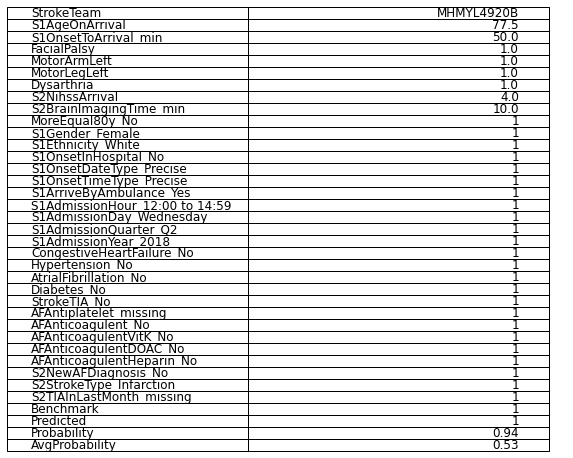

In [8]:
patient_data = [d for d in confident.iloc[3].values if d!=0]
patient_index = [d for i,d in enumerate(confident.columns.values) 
                 if confident.iloc[3].values[i]!=0]

df = pd.DataFrame(data=patient_data, index = patient_index, columns = ['Patient'])

fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
t= ax.table(cellText=df.values, colWidths = [0.9]*len(df.columns),  rowLabels=df.index,  loc='center')
t.auto_set_font_size(False) 
t.set_fontsize(12)
#plt.tight_layout()
plt.show()

In [9]:
df.to_csv('./data/vignettes/confident_example.csv', index_label = 'Features')

Venn diagram for vignette hospital

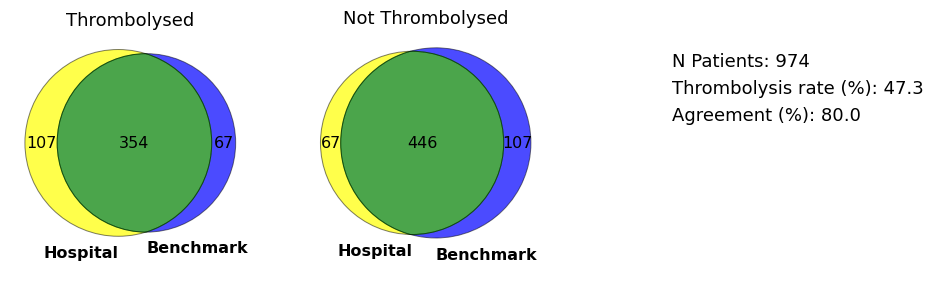

In [10]:
plot_venn(data, 'MHMYL4920B', save=True)

Graphviz diagram for vignette hospital

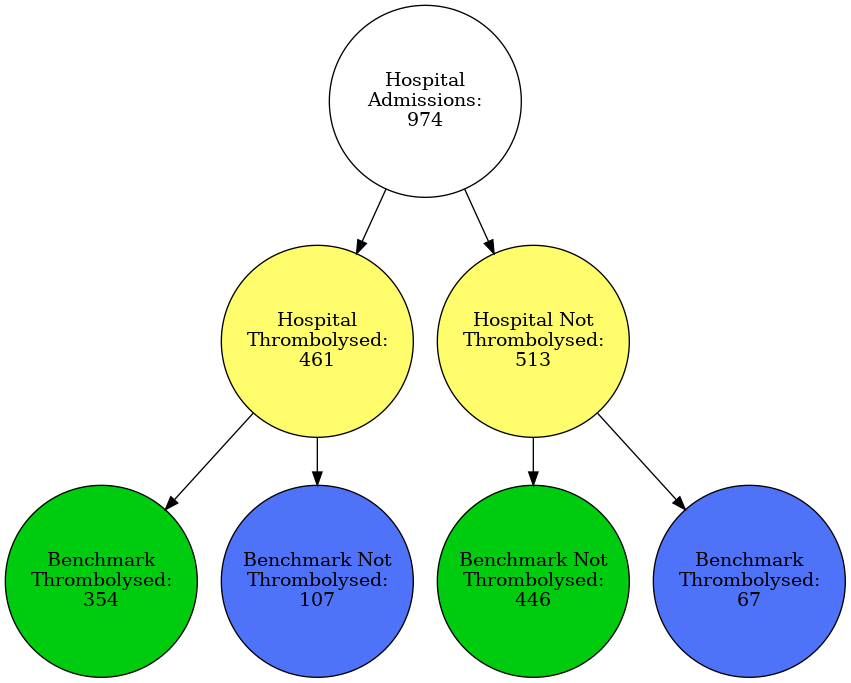

In [11]:
hosp = 'MHMYL4920B'
plot_graph(data, hosp)
filename = f'./figures/vignettes/graph_{hosp}.gv.png'
Image(filename=filename)

### Hospital with low treatment of patients with mild stroke

Find a patient from a hospital that has a low thrombolysis rate in patients with minor strokes who had a minor stroke and wasn't thrombolysed but benchmark hospitals would have.

Load table of previously calculated use and ratios by stroke severity and prior disability. This table provides use of thrombolysis in mild stroke (NIHSS 0-4) and moderate to sever stroke (NIHSS 16-20), and use in patients with no prior disability (modified Rankin Scale 0-1) and with prior disability (modified Rankin Scale 2+), and the rations between those groups.

In [12]:
ratios = pd.read_csv('./data/thrombolysis_ratios.csv')

In [13]:
ratios.head()

,StrokeTeam,minor,mod_severe,no_prior_disability,prior_disability,ratio_severity,ratio_disability
0,AGNOF1041H,0.171,0.463,0.398,0.235,0.370,0.589
1,AKCGO9726K,0.263,0.461,0.387,0.331,0.571,0.855
2,AOBTM3098N,0.029,0.337,0.246,0.157,0.087,0.640
3,APXEE8191H,0.070,0.341,0.263,0.140,0.205,0.534
4,ATDID5461S,0.156,0.290,0.296,0.131,0.539,0.442


In [14]:
minor_hospital = ratios.sort_values(by='minor')['StrokeTeam'].values[0]
ratios[ratios['StrokeTeam']==minor_hospital]

,StrokeTeam,minor,mod_severe,no_prior_disability,prior_disability,ratio_severity,ratio_disability
55,LFPMM4706C,0.006,0.152,0.069,0.047,0.041,0.675


The average use of thrombolysis in mild stroke (NIHSS 0-4) across hospitals is 12.9% of patients arriving within 4 hours of known stroke onset. This rate is, on average, 33% that of moderate to severe stroke (NIHSS 16-20). 

LFPMM4706C is a stroke team that uses thrombolysis in 0.6% of mild stroke, 4% of the use rate in moderate to severe stroke in the same hospital.

In [15]:
minor = data.loc[(data['StrokeTeam'] == minor_hospital) & (data['S2NihssArrival']<=5) \
            & (data['Benchmark'] == 1) & (data['S2Thrombolysis']==0)]

In [16]:
minor

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,MotorArmLeft,MotorArmRight,MotorLegLeft,MotorLegRight,LimbAtaxia,Sensory,BestLanguage,Dysarthria,ExtinctionInattention,S2NihssArrival,S2BrainImagingTime_min,MoreEqual80y_No,MoreEqual80y_Yes,S1Gender_Female,S1Gender_Male,S1Ethnicity_Asian,S1Ethnicity_Black,S1Ethnicity_Mixed,S1Ethnicity_Other,S1Ethnicity_White,S1OnsetInHospital_No,S1OnsetInHospital_Yes,S1OnsetDateType_Best estimate,S1OnsetDateType_Precise,S1OnsetDateType_Stroke during sleep,S1OnsetTimeType_Best estimate,S1OnsetTimeType_Not known,S1OnsetTimeType_Precise,S1ArriveByAmbulance_No,S1ArriveByAmbulance_Yes,S1ArriveByAmbulance_missing,S1AdmissionHour_00:00 to 02:59,S1AdmissionHour_03:00 to 05:59,S1AdmissionHour_06:00 to 08:59,S1AdmissionHour_09:00 to 11:59,S1AdmissionHour_12:00 to 14:59,S1AdmissionHour_15:00 to 17:59,S1AdmissionHour_18:00 to 20:59,S1AdmissionHour_21:00 to 23:59,S1AdmissionDay_Friday,S1AdmissionDay_Monday,S1AdmissionDay_Saturday,S1AdmissionDay_Sunday,S1AdmissionDay_Thursday,S1AdmissionDay_Tuesday,S1AdmissionDay_Wednesday,S1AdmissionQuarter_Q1,S1AdmissionQuarter_Q2,S1AdmissionQuarter_Q3,S1AdmissionQuarter_Q4,S1AdmissionYear_2016,S1AdmissionYear_2017,S1AdmissionYear_2018,CongestiveHeartFailure_No,CongestiveHeartFailure_Yes,Hypertension_No,Hypertension_Yes,AtrialFibrillation_No,AtrialFibrillation_Yes,Diabetes_No,Diabetes_Yes,StrokeTIA_No,StrokeTIA_Yes,AFAntiplatelet_No,AFAntiplatelet_No but,AFAntiplatelet_Yes,AFAntiplatelet_missing,AFAnticoagulent_No,AFAnticoagulent_No but,AFAnticoagulent_Yes,AFAnticoagulent_missing,AFAnticoagulentVitK_No,AFAnticoagulentVitK_Yes,AFAnticoagulentVitK_missing,AFAnticoagulentDOAC_No,AFAnticoagulentDOAC_Yes,AFAnticoagulentDOAC_missing,AFAnticoagulentHeparin_No,AFAnticoagulentHeparin_Yes,AFAnticoagulentHeparin_missing,S2NewAFDiagnosis_No,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis,Benchmark,Majority_90,Majority_80,Predicted,Probability,AvgProbability
53644,LFPMM4706C,82.5,56.0,0,0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0.30,0.41
53656,LFPMM4706C,32.5,66.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,59.0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.13,0.35
53674,LFPMM4706C,77.5,88.0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,5.0,31.0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0.06,0.41
53769,LFPMM4706C,62.5,80.0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,24.0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.24,0.34
53823,LFPMM4706C,72.5,125.0,3,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0,29.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0.28,0.44
53828,LFPMM4706C,57.5,95.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,30.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.14,0.32
53838,LFPMM4706C,82.5,194.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,16.0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,

Venn and GraphViz diagams for hospital with lowest thrombolysi use in mild strokes

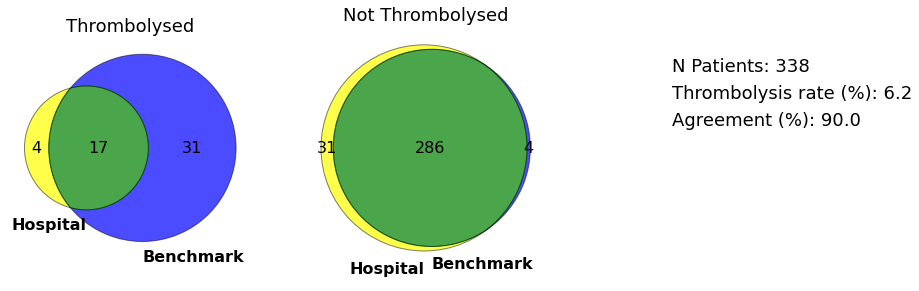

In [17]:
plot_venn(data, minor_hospital, save=True)

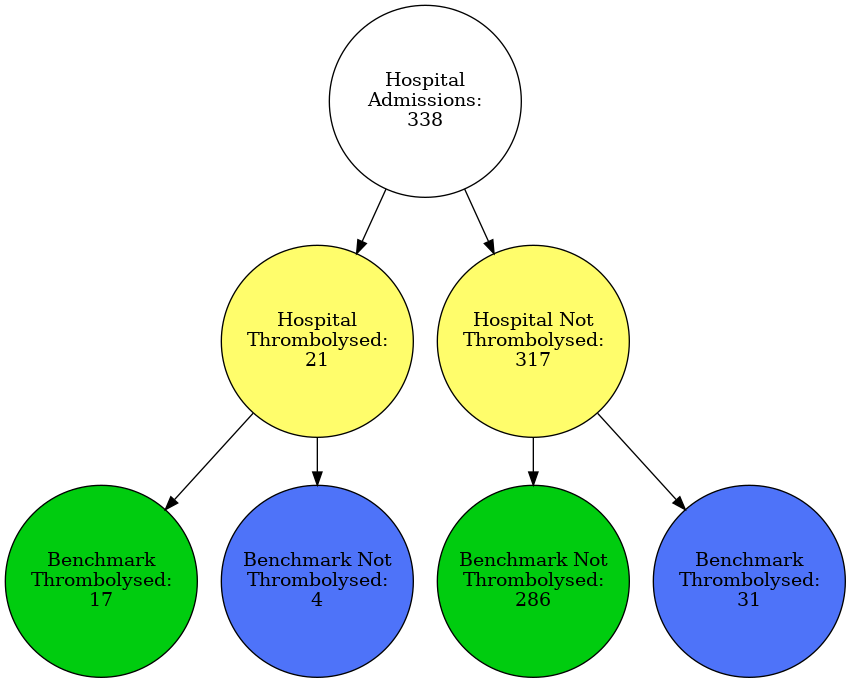

In [18]:
plot_graph(data, minor_hospital)
filename = f'./figures/vignettes/graph_{minor_hospital}.gv.png'
Image(filename=filename)

Create vignette for a mild stroke patient at a hospital with low thrombolysis use in mild strokes

In [19]:
minor

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,MotorArmLeft,MotorArmRight,MotorLegLeft,MotorLegRight,LimbAtaxia,Sensory,BestLanguage,Dysarthria,ExtinctionInattention,S2NihssArrival,S2BrainImagingTime_min,MoreEqual80y_No,MoreEqual80y_Yes,S1Gender_Female,S1Gender_Male,S1Ethnicity_Asian,S1Ethnicity_Black,S1Ethnicity_Mixed,S1Ethnicity_Other,S1Ethnicity_White,S1OnsetInHospital_No,S1OnsetInHospital_Yes,S1OnsetDateType_Best estimate,S1OnsetDateType_Precise,S1OnsetDateType_Stroke during sleep,S1OnsetTimeType_Best estimate,S1OnsetTimeType_Not known,S1OnsetTimeType_Precise,S1ArriveByAmbulance_No,S1ArriveByAmbulance_Yes,S1ArriveByAmbulance_missing,S1AdmissionHour_00:00 to 02:59,S1AdmissionHour_03:00 to 05:59,S1AdmissionHour_06:00 to 08:59,S1AdmissionHour_09:00 to 11:59,S1AdmissionHour_12:00 to 14:59,S1AdmissionHour_15:00 to 17:59,S1AdmissionHour_18:00 to 20:59,S1AdmissionHour_21:00 to 23:59,S1AdmissionDay_Friday,S1AdmissionDay_Monday,S1AdmissionDay_Saturday,S1AdmissionDay_Sunday,S1AdmissionDay_Thursday,S1AdmissionDay_Tuesday,S1AdmissionDay_Wednesday,S1AdmissionQuarter_Q1,S1AdmissionQuarter_Q2,S1AdmissionQuarter_Q3,S1AdmissionQuarter_Q4,S1AdmissionYear_2016,S1AdmissionYear_2017,S1AdmissionYear_2018,CongestiveHeartFailure_No,CongestiveHeartFailure_Yes,Hypertension_No,Hypertension_Yes,AtrialFibrillation_No,AtrialFibrillation_Yes,Diabetes_No,Diabetes_Yes,StrokeTIA_No,StrokeTIA_Yes,AFAntiplatelet_No,AFAntiplatelet_No but,AFAntiplatelet_Yes,AFAntiplatelet_missing,AFAnticoagulent_No,AFAnticoagulent_No but,AFAnticoagulent_Yes,AFAnticoagulent_missing,AFAnticoagulentVitK_No,AFAnticoagulentVitK_Yes,AFAnticoagulentVitK_missing,AFAnticoagulentDOAC_No,AFAnticoagulentDOAC_Yes,AFAnticoagulentDOAC_missing,AFAnticoagulentHeparin_No,AFAnticoagulentHeparin_Yes,AFAnticoagulentHeparin_missing,S2NewAFDiagnosis_No,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis,Benchmark,Majority_90,Majority_80,Predicted,Probability,AvgProbability
53644,LFPMM4706C,82.5,56.0,0,0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0.30,0.41
53656,LFPMM4706C,32.5,66.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,59.0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.13,0.35
53674,LFPMM4706C,77.5,88.0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,5.0,31.0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0.06,0.41
53769,LFPMM4706C,62.5,80.0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,24.0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.24,0.34
53823,LFPMM4706C,72.5,125.0,3,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0,29.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0.28,0.44
53828,LFPMM4706C,57.5,95.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,30.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.14,0.32
53838,LFPMM4706C,82.5,194.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,16.0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,

Patient at iloc 2 ( iloc 0 was predicted thrombolysed, iloc 1 is very young)

- Age: 77.5
- Onset to arrival: 88 mins
- Rankin before: 1
- Facial palsy: 1
- Motor arm right: 1
- Motor leg right: 1
- Limb ataxia: 1
- Sensory: 1
- NIHSS: 5
- Brain imaging time: 31 mins
- White Female
- Precise onset time
- Admitted between 6 and 9pm on Thursday, quarter 1, 2018
- No Diabetes, Congestive Heart Failure or Atrial Fibrillation
- Yes to Stroke TIA and Hypertension
- No record of antiplatelet or anticoagulent 
- No TIA in last month
- Probability of thrombolysis in this hospital = 0!

Sally is a 76 year old woman with hypertension who had a TIA three years ago, who was taking clopidogrel, bendroflumethiazide and a statin.  She found her knee arthritis a bit of a nuisance when shopping.  She started to feel a slight weakness in her left arm and leg as she was making dinner for herself and her husband, Roy, one Thursday evening. She thought her knee was playing up and put the 6 O'Clock news on the radio to take her mind off it. However, when Sally and Roy sat down to eat at 7pm he noticed that she was clumsy with her fork and he thought her face looked twisted on the right. As she had previously had a TIA, Roy was alarmed and quickly dialled 999. An ambulance arrived within 10 minutes, and by 7:28 pm she was being assessed in the emergency department of her local hospital. 

The first doctor to see Sally quickly sent her for a CT brain scan, which happened at 7:59pm. Once back in the emergency department, the doctor assessing Sally noted her history of hypertension and TIA but that she was otherwise generally well. The doctor noted a minor drooping of her face, and a drift of her left arm and leg which were also slightly numb, and it seemed to make her left arm rather clumsy.  Her NIHSS was 5.  The scan showed no signs of haemorrhage, but there was an old lacunar infarct in the left hemisphere. The doctor decided that the risks of thrombolysis outweighed her potential to benefit as she thought the natural prognosis from her mild stroke was good even without thrombolysis. She subsequently admitted her to the stroke unit for observation.

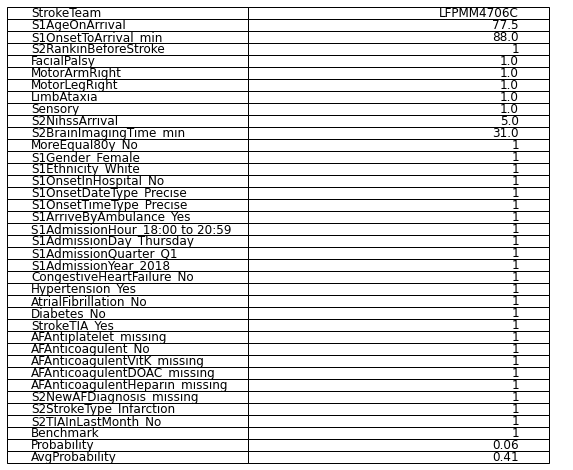

In [20]:
patient_data = [d for d in minor.iloc[2].values if d!=0]
patient_index = [d for i,d in enumerate(minor.columns.values) 
                 if minor.iloc[2].values[i]!=0]

df = pd.DataFrame(data=patient_data, index = patient_index, columns = ['Patient'])

fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
t= ax.table(cellText=df.values, colWidths = [0.9]*len(df.columns),  rowLabels=df.index,  loc='center')
t.auto_set_font_size(False) 
t.set_fontsize(12)
#plt.tight_layout()
plt.show()

In [21]:
df.to_csv('./data/vignettes/minor_example.csv', index_label = 'Features')

### Hospital with low use of thrombolysis in patients with prior disability 

#### Example 1

Find patients from a hospital that has a low rate of thrombolysis in patients with prior disability that:

- had high disability
- lost speech
- wasn't thrombolysed
- benchmark would have thrombolysed

In [22]:
disability_hospital = ratios.sort_values(by='prior_disability')['StrokeTeam'].values[0]

In [23]:
disability = data.loc[(data['StrokeTeam'] == disability_hospital)\
                      & (data['S2RankinBeforeStroke']>=2) & (data['Dysarthria']>=2)\
            & (data['Benchmark'] == 1) & (data['S2Thrombolysis']==0)]

In [24]:
disability

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,MotorArmLeft,MotorArmRight,MotorLegLeft,MotorLegRight,LimbAtaxia,Sensory,BestLanguage,Dysarthria,ExtinctionInattention,S2NihssArrival,S2BrainImagingTime_min,MoreEqual80y_No,MoreEqual80y_Yes,S1Gender_Female,S1Gender_Male,S1Ethnicity_Asian,S1Ethnicity_Black,S1Ethnicity_Mixed,S1Ethnicity_Other,S1Ethnicity_White,S1OnsetInHospital_No,S1OnsetInHospital_Yes,S1OnsetDateType_Best estimate,S1OnsetDateType_Precise,S1OnsetDateType_Stroke during sleep,S1OnsetTimeType_Best estimate,S1OnsetTimeType_Not known,S1OnsetTimeType_Precise,S1ArriveByAmbulance_No,S1ArriveByAmbulance_Yes,S1ArriveByAmbulance_missing,S1AdmissionHour_00:00 to 02:59,S1AdmissionHour_03:00 to 05:59,S1AdmissionHour_06:00 to 08:59,S1AdmissionHour_09:00 to 11:59,S1AdmissionHour_12:00 to 14:59,S1AdmissionHour_15:00 to 17:59,S1AdmissionHour_18:00 to 20:59,S1AdmissionHour_21:00 to 23:59,S1AdmissionDay_Friday,S1AdmissionDay_Monday,S1AdmissionDay_Saturday,S1AdmissionDay_Sunday,S1AdmissionDay_Thursday,S1AdmissionDay_Tuesday,S1AdmissionDay_Wednesday,S1AdmissionQuarter_Q1,S1AdmissionQuarter_Q2,S1AdmissionQuarter_Q3,S1AdmissionQuarter_Q4,S1AdmissionYear_2016,S1AdmissionYear_2017,S1AdmissionYear_2018,CongestiveHeartFailure_No,CongestiveHeartFailure_Yes,Hypertension_No,Hypertension_Yes,AtrialFibrillation_No,AtrialFibrillation_Yes,Diabetes_No,Diabetes_Yes,StrokeTIA_No,StrokeTIA_Yes,AFAntiplatelet_No,AFAntiplatelet_No but,AFAntiplatelet_Yes,AFAntiplatelet_missing,AFAnticoagulent_No,AFAnticoagulent_No but,AFAnticoagulent_Yes,AFAnticoagulent_missing,AFAnticoagulentVitK_No,AFAnticoagulentVitK_Yes,AFAnticoagulentVitK_missing,AFAnticoagulentDOAC_No,AFAnticoagulentDOAC_Yes,AFAnticoagulentDOAC_missing,AFAnticoagulentHeparin_No,AFAnticoagulentHeparin_Yes,AFAnticoagulentHeparin_missing,S2NewAFDiagnosis_No,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis,Benchmark,Majority_90,Majority_80,Predicted,Probability,AvgProbability
75693,OUXUZ1084Q,87.5,110.0,3,0,2.0,2.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,17.0,37.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.25,0.46
75708,OUXUZ1084Q,82.5,151.0,3,0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,13.0,9.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0.22,0.56
75731,OUXUZ1084Q,97.5,108.0,2,1,2.0,0.0,2.0,0.0,1.0,4.0,0.0,4.0,0.0,2.0,0.0,2.0,2.0,0.0,20.0,29.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.15,0.36
75821,OUXUZ1084Q,82.5,80.0,3,1,2.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,4.0,0.0,1.0,3.0,2.0,2.0,22.0,30.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.23,0.45
75919,OUXUZ1084Q,92.5,122.0,3,0,2.0,2.0,1.0,3.0,1.0,0.0,4.0,0.0,3.0,0.0,2.0,3.0,2.0,2.0,25.0,28.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0.15,0.35
75988,OUXUZ1084Q,92.5,94.0,3,3,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,3.0,2.0,2.0,36.0,13.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.23,0.41


The average use of thrombolysis in patients with prior disability (mRS 2+) is 18.9% of patients arriving within 4 hours of known stroke onset. This rate is, on average, 58% that of patients with no prior disability (mRS 0-1).

OUXUZ1084Q is a stroke team that uses thrombolysis in 2.3% of patients with prior disability, 10% of the use rate in patients with no prior disability.

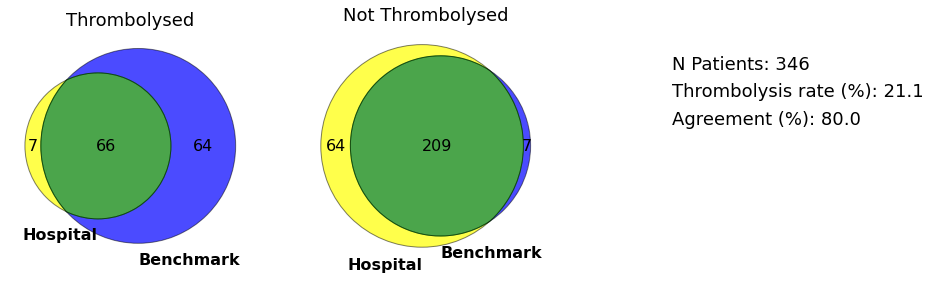

In [25]:
plot_venn(data, disability_hospital, save=True)

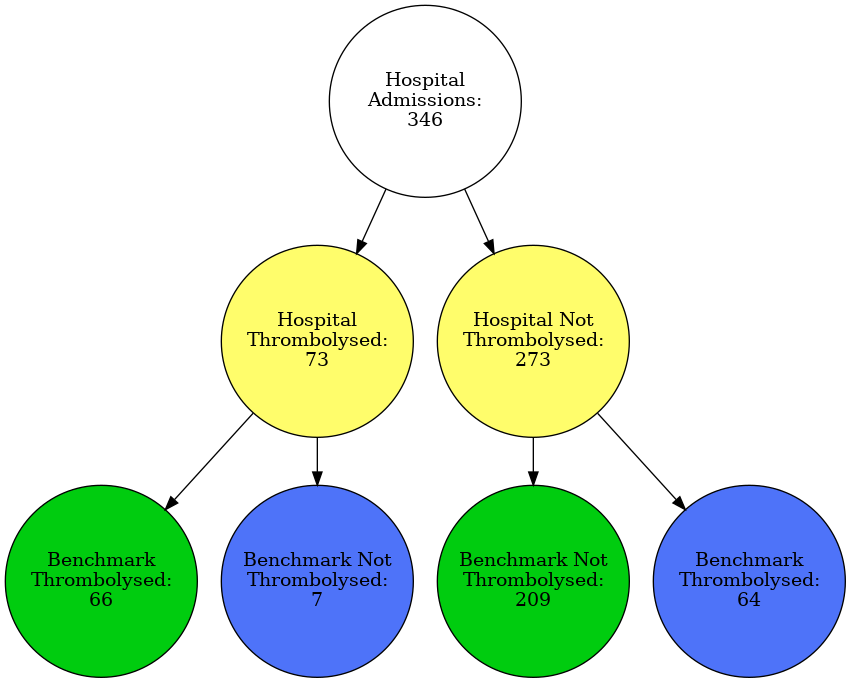

In [26]:
plot_graph(data, disability_hospital)
filename = f'./figures/vignettes/graph_{disability_hospital}.gv.png'
Image(filename=filename)

In [27]:
disability

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,MotorArmLeft,MotorArmRight,MotorLegLeft,MotorLegRight,LimbAtaxia,Sensory,BestLanguage,Dysarthria,ExtinctionInattention,S2NihssArrival,S2BrainImagingTime_min,MoreEqual80y_No,MoreEqual80y_Yes,S1Gender_Female,S1Gender_Male,S1Ethnicity_Asian,S1Ethnicity_Black,S1Ethnicity_Mixed,S1Ethnicity_Other,S1Ethnicity_White,S1OnsetInHospital_No,S1OnsetInHospital_Yes,S1OnsetDateType_Best estimate,S1OnsetDateType_Precise,S1OnsetDateType_Stroke during sleep,S1OnsetTimeType_Best estimate,S1OnsetTimeType_Not known,S1OnsetTimeType_Precise,S1ArriveByAmbulance_No,S1ArriveByAmbulance_Yes,S1ArriveByAmbulance_missing,S1AdmissionHour_00:00 to 02:59,S1AdmissionHour_03:00 to 05:59,S1AdmissionHour_06:00 to 08:59,S1AdmissionHour_09:00 to 11:59,S1AdmissionHour_12:00 to 14:59,S1AdmissionHour_15:00 to 17:59,S1AdmissionHour_18:00 to 20:59,S1AdmissionHour_21:00 to 23:59,S1AdmissionDay_Friday,S1AdmissionDay_Monday,S1AdmissionDay_Saturday,S1AdmissionDay_Sunday,S1AdmissionDay_Thursday,S1AdmissionDay_Tuesday,S1AdmissionDay_Wednesday,S1AdmissionQuarter_Q1,S1AdmissionQuarter_Q2,S1AdmissionQuarter_Q3,S1AdmissionQuarter_Q4,S1AdmissionYear_2016,S1AdmissionYear_2017,S1AdmissionYear_2018,CongestiveHeartFailure_No,CongestiveHeartFailure_Yes,Hypertension_No,Hypertension_Yes,AtrialFibrillation_No,AtrialFibrillation_Yes,Diabetes_No,Diabetes_Yes,StrokeTIA_No,StrokeTIA_Yes,AFAntiplatelet_No,AFAntiplatelet_No but,AFAntiplatelet_Yes,AFAntiplatelet_missing,AFAnticoagulent_No,AFAnticoagulent_No but,AFAnticoagulent_Yes,AFAnticoagulent_missing,AFAnticoagulentVitK_No,AFAnticoagulentVitK_Yes,AFAnticoagulentVitK_missing,AFAnticoagulentDOAC_No,AFAnticoagulentDOAC_Yes,AFAnticoagulentDOAC_missing,AFAnticoagulentHeparin_No,AFAnticoagulentHeparin_Yes,AFAnticoagulentHeparin_missing,S2NewAFDiagnosis_No,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis,Benchmark,Majority_90,Majority_80,Predicted,Probability,AvgProbability
75693,OUXUZ1084Q,87.5,110.0,3,0,2.0,2.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,17.0,37.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.25,0.46
75708,OUXUZ1084Q,82.5,151.0,3,0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,13.0,9.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0.22,0.56
75731,OUXUZ1084Q,97.5,108.0,2,1,2.0,0.0,2.0,0.0,1.0,4.0,0.0,4.0,0.0,2.0,0.0,2.0,2.0,0.0,20.0,29.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.15,0.36
75821,OUXUZ1084Q,82.5,80.0,3,1,2.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,4.0,0.0,1.0,3.0,2.0,2.0,22.0,30.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.23,0.45
75919,OUXUZ1084Q,92.5,122.0,3,0,2.0,2.0,1.0,3.0,1.0,0.0,4.0,0.0,3.0,0.0,2.0,3.0,2.0,2.0,25.0,28.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0.15,0.35
75988,OUXUZ1084Q,92.5,94.0,3,3,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,3.0,2.0,2.0,36.0,13.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.23,0.41


Patient at iloc 1 (benchmark and 80% majority would thrombolyse)

- Age: 82.5
- Onset to arrival: 151 mins
- Rankin before: 3
- LocQuestions: 1
- LocCommands: 1
- Visual: 2
- Facial palsy: 2
- Motor arm right: 1
- Motor leg right: 1
- Sensory: 1
- BestLanguage: 2
- Dysarthia: 2
- NIHSS: 13
- Brain imaging time: 9 mins
- White Female
- Precise onset time
- Admitted between 3 and 6pm on Tuesday, quarter 1, 2017
- No Diabetes, Congestive Heart Failure, StrokeTIA or Atrial Fibrillation
- Yes to Hypertension
- No record of antiplatelet, anticoagulent or newAFdiagnosis
- No recorded TIA in last month
- Probability of thrombolysis in this hospital = 0.22

Mabel is 84 years old and, since her husband passed away, has lived in a residential home: although she is still mobile, Mabel requires some help with her day to day living due to memory decline. After finishing her lunch at 1pm on Tuesday, Katy, one of the staff, came over to take her plate to the kitchen. Katy always enjoyed a chat with Mabel however, as they were talking, Mabel started to slur her words and very quickly it became hard for Katy to understand what she was saying. Knowing the signs of stroke, Katy quickly called for an ambulance.

Unfortunately, due to a serious incident nearby, the ambulance almost 2 hours to arrive. Once it did arrive, Mabel was quickly taken to the nearest stroke unit. She arrived at 3:30pm and had a brain scan within 10 minutes. The clinician assessing her found her stroke was moderate, scoring 13 on the NIH stroke scale. Mabel had previously been diagnosed with hypertension but was otherwise healthy for her age. Mabel was admitted to the stroke unit but was not offered thrombolysis.

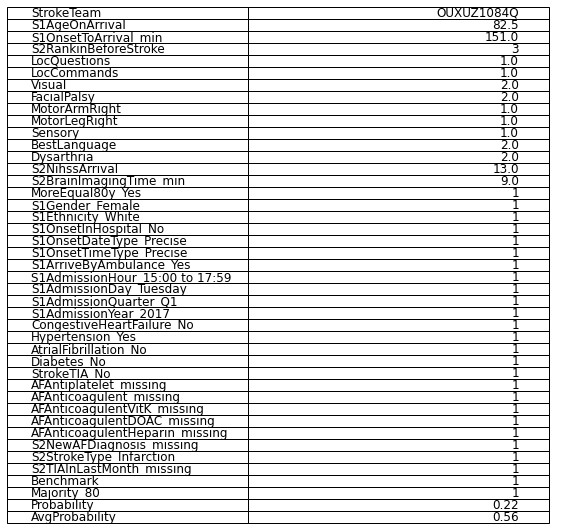

In [28]:
patient_data = [d for d in disability.iloc[1].values if d!=0]
patient_index = [d for i,d in enumerate(disability.columns.values) 
                 if disability.iloc[1].values[i]!=0]

df = pd.DataFrame(data=patient_data, index = patient_index, columns = ['Patient'])

fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
t= ax.table(cellText=df.values, colWidths = [0.9]*len(df.columns),  rowLabels=df.index,  loc='center')
t.auto_set_font_size(False) 
t.set_fontsize(12)
#plt.tight_layout()
plt.show()

In [29]:
df.to_csv('./data/vignettes/disability_example.csv', index_label = 'Features')

#### Example 2

Rankin = 4 and NIHSS < 10 

In [30]:
disability = data.loc[(data['S2RankinBeforeStroke']>=4) & (data['Dysarthria']>=2)\
            & (data['Benchmark'] == 1) & (data['S2Thrombolysis']==0)\
                     & (data['S2NihssArrival']<10) & (data['Predicted']==0)]#['Dysarthria']

In [31]:
disability

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,MotorArmLeft,MotorArmRight,MotorLegLeft,MotorLegRight,LimbAtaxia,Sensory,BestLanguage,Dysarthria,ExtinctionInattention,S2NihssArrival,S2BrainImagingTime_min,MoreEqual80y_No,MoreEqual80y_Yes,S1Gender_Female,S1Gender_Male,S1Ethnicity_Asian,S1Ethnicity_Black,S1Ethnicity_Mixed,S1Ethnicity_Other,S1Ethnicity_White,S1OnsetInHospital_No,S1OnsetInHospital_Yes,S1OnsetDateType_Best estimate,S1OnsetDateType_Precise,S1OnsetDateType_Stroke during sleep,S1OnsetTimeType_Best estimate,S1OnsetTimeType_Not known,S1OnsetTimeType_Precise,S1ArriveByAmbulance_No,S1ArriveByAmbulance_Yes,S1ArriveByAmbulance_missing,S1AdmissionHour_00:00 to 02:59,S1AdmissionHour_03:00 to 05:59,S1AdmissionHour_06:00 to 08:59,S1AdmissionHour_09:00 to 11:59,S1AdmissionHour_12:00 to 14:59,S1AdmissionHour_15:00 to 17:59,S1AdmissionHour_18:00 to 20:59,S1AdmissionHour_21:00 to 23:59,S1AdmissionDay_Friday,S1AdmissionDay_Monday,S1AdmissionDay_Saturday,S1AdmissionDay_Sunday,S1AdmissionDay_Thursday,S1AdmissionDay_Tuesday,S1AdmissionDay_Wednesday,S1AdmissionQuarter_Q1,S1AdmissionQuarter_Q2,S1AdmissionQuarter_Q3,S1AdmissionQuarter_Q4,S1AdmissionYear_2016,S1AdmissionYear_2017,S1AdmissionYear_2018,CongestiveHeartFailure_No,CongestiveHeartFailure_Yes,Hypertension_No,Hypertension_Yes,AtrialFibrillation_No,AtrialFibrillation_Yes,Diabetes_No,Diabetes_Yes,StrokeTIA_No,StrokeTIA_Yes,AFAntiplatelet_No,AFAntiplatelet_No but,AFAntiplatelet_Yes,AFAntiplatelet_missing,AFAnticoagulent_No,AFAnticoagulent_No but,AFAnticoagulent_Yes,AFAnticoagulent_missing,AFAnticoagulentVitK_No,AFAnticoagulentVitK_Yes,AFAnticoagulentVitK_missing,AFAnticoagulentDOAC_No,AFAnticoagulentDOAC_Yes,AFAnticoagulentDOAC_missing,AFAnticoagulentHeparin_No,AFAnticoagulentHeparin_Yes,AFAnticoagulentHeparin_missing,S2NewAFDiagnosis_No,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis,Benchmark,Majority_90,Majority_80,Predicted,Probability,AvgProbability
6244,JINXD0311F,97.5,71.0,4,0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,9.0,19.0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0.39,0.43
9961,AGNOF1041H,87.5,79.0,4,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,5.0,4.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.30,0.40
19408,QNARI2373R,97.5,188.0,4,0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,9.0,30.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0.29,0.35
22320,ROOIZ9592Y,82.5,179.0,4,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,7.0,12.0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.40,0.38
23496,ISIZF6614O,57.5,109.0,4,1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,13.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.39,0.41
33217,UIWEN7236N,82.5,79.0,4,0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,9.0,27.0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0.33,0.31
34529,JADBS8258F,72.5,73.0,4,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,6.0,22.0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,

##### Patient at iloc -1

- Age: 82.5
- Onset to arrival: 117 mins
- Rankin before: 4
- Loc: 1
- LocQuestions: 1
- Best Gaze: 2
- BestLanguage: 1
- Dysarthia: 2
- Extinction Inattention: 1
- NIHSS: 8
- Brain imaging time: 21 mins
- White Female
- Precise onset time
- Admitted between 3 and 6pm on Sunday, quarter 4, 2017
- No Diabetes, Congestive Heart Failure, StrokeTIA or Hypertension
- Yes to Atrial Fibrillation and AF Anit Platelet
- No anticoagulent or newAFdiagnosis
- No recorded TIA in last month
- Probability of thrombolysis in this hospital = 0.33

Mabel is 84 years old and, since her husband passed away, has lived in a residential home: although she is still mobile with assistance, Mabel requires help with her day to day activities due to her memory problems, and couldn’t be left on her own for any length of time. After finishing her lunch at 1:30pm one Sunday, Katy, one of the staff, helped her to walk back to her room. When Katy went back to check on Mabel an hour later, it was very hard for Katy to understand what she was saying. Knowing the signs of stroke, Katy quickly called for an ambulance, which arrived 20 minutes later.

Mabel arrived at her local hospital at 3:27pm and had a CT brain scan within 25 minutes. The clinician assessing her found her a bit drowsy and disorientated, struggling to speak clearly, with her attention less readily drawn to the left side but no limb weakness, scoring 8 on the NIH stroke scale although this seemed to be overstated by her dementia. Mabel’s CT scan showed significant cerebral atrophy with confluent symmetrical hypodensities suggesting an advanced vascular dementia.  Given her severe pre-existing disability and the advanced vascular changes on her CT scan, the admitting doctor considered the risks of haemorrhage to be high, and her chances of responding to thrombolysis with a meaningful reduction in her disability to be low, and so she admitted her to the stroke unit directly without thrombolysis.

In [32]:
patient_data = [d for d in disability.iloc[-1].values if d!=0]
patient_index = [d for i,d in enumerate(disability.columns.values) 
                 if disability.iloc[-1].values[i]!=0]

df = pd.DataFrame(data=patient_data, index = patient_index, columns = ['Patient'])

df.to_csv('./data/vignettes/disability_example_2.csv', index_label = 'Features')

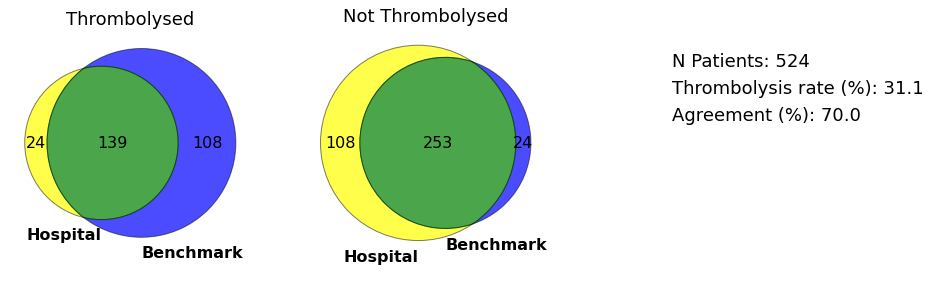

In [33]:
plot_venn(data, 'BICAW1125K', save=True)

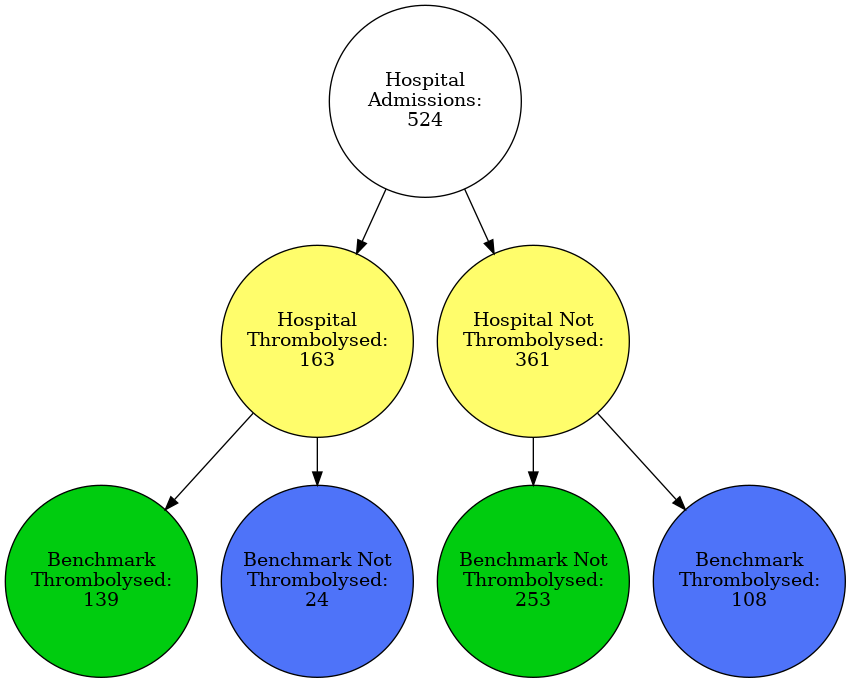

In [34]:
hosp = 'BICAW1125K'
plot_graph(data, hosp)
filename = f'./figures/vignettes/graph_{hosp}.gv.png'
Image(filename=filename)

## Observations

* We illustrate methods of visualisation of use of thrombolysis compared with benchmark hospitals.

* We can identify hospitals with a pre-determined difference in use of thrombolysis, and compare to other hospitals though hospital-level diagrams or patient vignettes.

* Feedback during workshops with physicians was that the Venn diagrams were difficult to understand; we then added the Graph diagrams as a result

* The synthetic patient vignettes were popular as a discussion tool at the workshop with physicians. 